In [2]:
# Install required packages for CHIRPS analysis
%pip install matplotlib seaborn cartopy scikit-learn netcdf4 rasterio rioxarray dask

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/33/cd/b145f9797126f3f809d177ca378de57c45413c5099c5990de2658760594a/matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata
  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for cartopy from https://files.pythonhosted.org/packages/4b/c0/b33ac1f586608e80a5e10f3924e16c117da333fcb5e5240839e6681ac3d5/cartopy-0.25.0-cp311-cp311-win_amd64.whl.metadata
  Using cached cartopy-0.25.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Obtaining dependency information for scikit-learn from https://files.pythonhosted


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# CHIRPS Version 2 vs Version 3 Data Analysis

## Comprehensive Comparison for Year 2020 (6-Month Period)

This notebook provides a detailed analysis comparing CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data) Version 2 and Version 3 for 6 months of 2020 (January-June). We'll examine:

1. **Data Acquisition and Processing** - Real data from CHC Portal
2. **Statistical Comparisons**
3. **Spatial Analysis**
4. **Temporal Patterns**
5. **Impact Assessment on Applications**
6. **Conclusions and Recommendations**

### Key Questions to Address:
- How significant are the differences between versions?
- What are the spatial patterns of change?
- Which regions show the most variation?
- What implications exist for existing applications using CHIRPS v2?

**Note**: We're downloading real CHIRPS data (not synthetic) from the CHC Data Portal. The 6-month period keeps file sizes manageable (~120-240 MB per version).

---

In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import requests
from datetime import datetime, timedelta
import os
from pathlib import Path
import rasterio
import rioxarray
from calendar import monthrange

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("Libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Create output directory for figures
output_dir = Path("chirps_analysis_output")
output_dir.mkdir(exist_ok=True)
print(f"Output directory created: {output_dir}")

# Configuration
ANALYSIS_YEAR = 2020  # Changed to 2020 as CHIRPS v3 is not available for 2005
SPATIAL_EXTENT = {
    'lat_min': -60, 'lat_max': 60,
    'lon_min': -180, 'lon_max': 180
}

print(f"Analysis configured for year: {ANALYSIS_YEAR}")
print(f"Spatial extent: {SPATIAL_EXTENT}")

Libraries imported successfully!
Analysis Date: 2025-10-31 16:35:12
Output directory created: chirps_analysis_output
Analysis configured for year: 2020
Spatial extent: {'lat_min': -60, 'lat_max': 60, 'lon_min': -180, 'lon_max': 180}


## 1. Data Acquisition

We'll download **real CHIRPS data** directly from the CHC Data Portal for 6 months (January-June) to keep file sizes manageable.

**CHIRPS Version 2 (v2.0):**
- Available since 2015
- Based on 0.05° resolution (~5.3 km at equator)
- Uses CHPclim + station data + satellite estimates
- Standard algorithm

**CHIRPS Version 3 (v3.0):**
- Released in recent years
- Improved algorithm and calibration
- Enhanced station network integration
- Better bias correction techniques

### Data Sources:
- **CHIRPS v2**: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/by_month/ (monthly NetCDF)
- **CHIRPS v3**: https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/YYYY/ (daily TIF)

### Download Strategy:
- **Period**: 6 months (January-June 2020)
- **v2 Format**: Monthly NetCDF files (~20-40 MB per month)
- **v3 Format**: Daily TIF files (~1-2 MB per day), converted to NetCDF
- **Total size**: Approximately 120-240 MB for v2, 180-360 MB for v3 (before conversion)
- **Note**: CHIRPS v3 is available from 2017 onwards with daily TIF files.

In [12]:
# Download Real CHIRPS Data from CHC Portal
print("="*70)
print("DOWNLOADING REAL CHIRPS DATA FROM CHC PORTAL")
print("="*70)

# Create data directory
data_dir = Path("chirps_data")
data_dir.mkdir(exist_ok=True)

# Configuration for 6-month analysis (January-June)
START_MONTH = 1
END_MONTH = 6
MONTHS_TO_DOWNLOAD = range(START_MONTH, END_MONTH + 1)

print(f"\nDownloading {len(MONTHS_TO_DOWNLOAD)} months of data for {ANALYSIS_YEAR}")
print(f"Period: {ANALYSIS_YEAR}-{START_MONTH:02d} to {ANALYSIS_YEAR}-{END_MONTH:02d}")
print(f"Note: CHIRPS v3 may not be available for all years. Checking availability...")

# Configuration for analysis - EXPANDED TO 12 MONTHS (FULL YEAR)
START_MONTH = 1
END_MONTH = 12  # Full 12-month analysis (January-December)
MONTHS_TO_DOWNLOAD = range(START_MONTH, END_MONTH + 1)

print(f"\nDownloading {len(MONTHS_TO_DOWNLOAD)} months of data for {ANALYSIS_YEAR}")
print(f"Period: {ANALYSIS_YEAR}-{START_MONTH:02d} to {ANALYSIS_YEAR}-{END_MONTH:02d}")
print(f"Note: CHIRPS v2 uses monthly NetCDF files, v3 uses daily TIF files.")
print(f"📊 Analyzing FULL YEAR ({len(MONTHS_TO_DOWNLOAD)} months) for complete seasonal coverage")

def download_chirps_v2_monthly(year, months, output_dir):
    """
    Download CHIRPS v2 data (monthly NetCDF files)
    
    Parameters:
    -----------
    year : int
        Year to download
    months : list
        List of months to download
    output_dir : Path
        Directory to save files
    
    Returns:
    --------
    list : Downloaded file paths
    """
    version_dir = output_dir / "chirps_v2"
    version_dir.mkdir(exist_ok=True)
    
    downloaded_files = []
    base_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/by_month/"
    
    for month in months:
        filename = f"chirps-v2.0.{year}.{month:02d}.days_p05.nc"
        filepath = version_dir / filename
        
        if filepath.exists():
            print(f"✓ {filename} already exists. Skipping download.")
            downloaded_files.append(filepath)
            continue
        
        url = base_url + filename
        
        try:
            print(f"📥 Downloading {filename}...")
            print(f"   URL: {url}")
            
            response = requests.get(url, stream=True, timeout=300)
            response.raise_for_status()
            
            file_size = int(response.headers.get('content-length', 0))
            file_size_mb = file_size / (1024 * 1024)
            print(f"   File size: {file_size_mb:.1f} MB")
            
            with open(filepath, 'wb') as f:
                downloaded = 0
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        downloaded += len(chunk)
                        if file_size > 0:
                            percent = (downloaded / file_size) * 100
                            print(f"   Progress: {percent:.1f}%", end='\r')
            
            print(f"\n✓ {filename} downloaded successfully!")
            downloaded_files.append(filepath)
            
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 404:
                print(f"⚠️  {filename} not found (404).")
            else:
                print(f"✗ HTTP Error: {e}")
        except Exception as e:
            print(f"✗ Error: {e}")
    
    return downloaded_files

def download_chirps_v3_daily(year, months, output_dir):
    """
    Download CHIRPS v3 data (daily TIF files)
    v3 URL pattern: https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/YYYY/chirps-v3.0.rnl.YYYY.MM.DD.tif
    
    Parameters:
    -----------
    year : int
        Year to download
    months : list
        List of months to download
    output_dir : Path
        Directory to save files
    
    Returns:
    --------
    list : Downloaded file paths
    """
    version_dir = output_dir / "chirps_v3"
    version_dir.mkdir(exist_ok=True)
    
    downloaded_files = []
    base_url = f"https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/{year}/"
    
    total_files = 0
    for month in months:
        days_in_month = monthrange(year, month)[1]
        total_files += days_in_month
    
    print(f"   Total files to download: {total_files} (daily TIF files)")
    
    file_count = 0
    for month in months:
        days_in_month = monthrange(year, month)[1]
        
        for day in range(1, days_in_month + 1):
            filename = f"chirps-v3.0.rnl.{year}.{month:02d}.{day:02d}.tif"
            filepath = version_dir / filename
            
            if filepath.exists():
                file_count += 1
                downloaded_files.append(filepath)
                continue
            
            url = base_url + filename
            
            try:
                if file_count == 0 or file_count % 10 == 0:  # Print every 10th file
                    print(f"📥 Downloading {filename}... ({file_count+1}/{total_files})")
                
                response = requests.get(url, stream=True, timeout=300)
                response.raise_for_status()
                
                with open(filepath, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
                
                downloaded_files.append(filepath)
                file_count += 1
                
                if file_count % 10 == 0:
                    print(f"   Progress: {file_count}/{total_files} files downloaded ({(file_count/total_files)*100:.1f}%)")
                
            except requests.exceptions.HTTPError as e:
                if e.response.status_code == 404:
                    print(f"⚠️  {filename} not found (404).")
                else:
                    print(f"✗ HTTP Error: {e}")
            except Exception as e:
                print(f"✗ Error downloading {filename}: {e}")
    
    print(f"\n✓ Downloaded {len(downloaded_files)} v3 TIF files")
    return downloaded_files

def load_v3_tifs_with_xarray(tif_files):
    """
    Load CHIRPS v3 daily TIF files using xarray's rasterio engine (memory efficient)
    Returns list of file paths for xarray to open with rioxarray
    """
    print("\n📦 Preparing v3 TIF files for xarray loading...")
    print(f"   Total TIF files available: {len(tif_files)}")
    print(f"   Note: Files will be loaded lazily by xarray to save memory")
    
    # Just return the file paths - xarray will load them lazily
    return tif_files

# Download CHIRPS v2 data
print("\n" + "="*70)
print("DOWNLOADING CHIRPS v2.0 DATA (Monthly NetCDF)")
print("="*70)
v2_files = download_chirps_v2_monthly(ANALYSIS_YEAR, MONTHS_TO_DOWNLOAD, data_dir)

# Download CHIRPS v3 data
print("\n" + "="*70)
print("DOWNLOADING CHIRPS v3.0 DATA (Daily TIF)")
print("="*70)
print("Note: v3 uses daily TIF files, so we'll download multiple files per month.")
v3_tif_files = download_chirps_v3_daily(ANALYSIS_YEAR, MONTHS_TO_DOWNLOAD, data_dir)

# Prepare v3 files for loading
v3_files = load_v3_tifs_with_xarray(v3_tif_files)

# Check if downloads were successful
print("\n" + "="*70)
print("DOWNLOAD SUMMARY")
print("="*70)
print(f"CHIRPS v2: {len(v2_files)} NetCDF file(s) downloaded")
print(f"CHIRPS v3: {len(v3_tif_files)} TIF file(s) downloaded")

if len(v2_files) == 0:
    raise FileNotFoundError("No CHIRPS v2 files were downloaded. Please check URLs and internet connection.")

if len(v3_files) == 0:
    print(f"\n⚠️  WARNING: No CHIRPS v3 files were downloaded.")
    print(f"CHIRPS v3 may not be available for the year {ANALYSIS_YEAR}.")
    print("\nOptions:")
    print("1. Check internet connection")
    print("2. Verify CHIRPS v3 availability at: https://data.chc.ucsb.edu/products/CHIRPS/v3.0/")
    raise FileNotFoundError(f"CHIRPS v3 data not available for {ANALYSIS_YEAR}")

# Load downloaded data
print("\n" + "="*70)
print("LOADING CHIRPS DATA INTO MEMORY (REGIONAL SUBSET)")
print("="*70)

# Define region of interest (Sub-Saharan Africa) - same as analysis region
# This significantly reduces memory requirements
REGION_BOUNDS = {
    'lat_min': -35,  # South
    'lat_max': 20,   # North
    'lon_min': -20,  # West
    'lon_max': 50    # East
}

print(f"\nRegion: {REGION_BOUNDS['lat_min']}°S to {REGION_BOUNDS['lat_max']}°N")
print(f"        {REGION_BOUNDS['lon_min']}°W to {REGION_BOUNDS['lon_max']}°E")
print("Note: Loading regional subset to manage memory efficiently")

print("\nLoading CHIRPS v2.0 (monthly NetCDF files) - Regional subset...")
v2_datasets = []
for i, v2_file in enumerate(v2_files):
    print(f"   Loading file {i+1}/{len(v2_files)}: {v2_file.name}")
    ds = xr.open_dataset(v2_file)
    
    # Check coordinates before selection
    if i == 0:
        print(f"   Original lat range: {float(ds.latitude.min()):.2f}° to {float(ds.latitude.max()):.2f}°")
        print(f"   Original lon range: {float(ds.longitude.min()):.2f}° to {float(ds.longitude.max()):.2f}°")
        print(f"   Latitude order: {'descending' if ds.latitude[0] > ds.latitude[-1] else 'ascending'}")
    
    # Extract regional subset immediately to save memory
    # Note: slice order depends on coordinate order
    if ds.latitude[0] > ds.latitude[-1]:  # Descending
        ds_region = ds.sel(
            latitude=slice(REGION_BOUNDS['lat_max'], REGION_BOUNDS['lat_min']),
            longitude=slice(REGION_BOUNDS['lon_min'], REGION_BOUNDS['lon_max'])
        )
    else:  # Ascending
        ds_region = ds.sel(
            latitude=slice(REGION_BOUNDS['lat_min'], REGION_BOUNDS['lat_max']),
            longitude=slice(REGION_BOUNDS['lon_min'], REGION_BOUNDS['lon_max'])
        )
    
    if i == 0:
        print(f"   Regional lat range: {float(ds_region.latitude.min()):.2f}° to {float(ds_region.latitude.max()):.2f}°")
        print(f"   Regional lon range: {float(ds_region.longitude.min()):.2f}° to {float(ds_region.longitude.max()):.2f}°")
        print(f"   Regional shape: {ds_region.dims}")
    
    v2_datasets.append(ds_region)
    ds.close()  # Close original to free memory

chirps_v2 = xr.concat(v2_datasets, dim='time')
print(f"✓ CHIRPS v2 loaded: {chirps_v2.dims}")
print(f"  Regional shape: {chirps_v2.precip.shape if 'precip' in chirps_v2 else chirps_v2.precipitation.shape}")

print("\nLoading CHIRPS v3.0 (daily TIF files) - Regional subset with memory optimization...")
print(f"⚠️  Processing {len(v3_files)} files - using chunked loading for {12}-month period")

# Use rioxarray with chunked loading for better memory management
v3_datasets = []
for i, tif_file in enumerate(v3_files):
    if i % 30 == 0:
        print(f"   Loading file {i+1}/{len(v3_files)}... (memory-efficient mode)")
    
    # Open with chunks to avoid loading full global file into memory at once
    da = rioxarray.open_rasterio(tif_file, masked=True, chunks={'x': 500, 'y': 500})
    
    # Extract date from filename and add as coordinate
    filename = tif_file.name
    year_str = filename.split('.')[3]
    month_str = filename.split('.')[4]  
    day_str = filename.split('.')[5]
    date = pd.Timestamp(f"{year_str}-{month_str}-{day_str}")
    
    da = da.squeeze().drop_vars('band', errors='ignore')
    
    # Extract regional subset FIRST before any operations to minimize memory
    if 'x' in da.coords and 'y' in da.coords:
        # Select region based on coordinate values - this reduces data size immediately
        da_region = da.sel(
            y=slice(REGION_BOUNDS['lat_max'], REGION_BOUNDS['lat_min']),
            x=slice(REGION_BOUNDS['lon_min'], REGION_BOUNDS['lon_max'])
        )
    else:
        da_region = da
    
    # Now apply masking only to the regional subset (much smaller!)
    da_region = da_region.where(da_region >= 0)
    
    # Check and display info for first file AFTER subsetting
    if i == 0:
        # Force computation for first file only to get diagnostics
        da_computed = da_region.compute()
        print(f"   ✓ Regional subset extracted successfully")
        print(f"   Regional data range: min={float(da_computed.min()):.2f}, max={float(da_computed.max()):.2f}")
        print(f"   Regional shape: {da_computed.shape}")
        print(f"   Memory per day: ~{da_computed.nbytes / (1024**2):.1f} MB")
        print(f"   Total estimated: ~{(da_computed.nbytes * len(v3_files)) / (1024**3):.2f} GB for all days")
        # Use computed version for first entry
        da_region = da_computed
    
    da_region = da_region.expand_dims(time=[date])
    v3_datasets.append(da_region)
    
    # Periodic garbage collection for long loops to prevent memory buildup
    if i % 50 == 0 and i > 0:
        import gc
        gc.collect()

print(f"\n   Concatenating {len(v3_datasets)} daily files into single dataset...")
print(f"   ⏳ This may take a few moments for {12} months of data...")
chirps_v3 = xr.concat(v3_datasets, dim='time')
chirps_v3 = chirps_v3.to_dataset(name='precip')

# Rename coordinates to match v2
if 'x' in chirps_v3.coords:
    chirps_v3 = chirps_v3.rename({'x': 'longitude', 'y': 'latitude'})

print(f"✓ CHIRPS v3 loaded successfully!")
print(f"  Dimensions: {chirps_v3.dims}")
print(f"  Regional shape: {chirps_v3.precip.shape}")
print(f"  Time range: {chirps_v3.time.min().values} to {chirps_v3.time.max().values}")

# Standardize variable names (CHIRPS uses 'precip' or 'precipitation')
if 'precipitation' in chirps_v2.variables and 'precip' not in chirps_v2.variables:
    chirps_v2 = chirps_v2.rename({'precipitation': 'precip'})
if 'precipitation' in chirps_v3.variables and 'precip' not in chirps_v3.variables:
    chirps_v3 = chirps_v3.rename({'precipitation': 'precip'})

print("\n" + "="*70)
print("DATA SUMMARY")
print("="*70)
print(f"\nCHIRPS v2.0:")
var_name_v2 = 'precip' if 'precip' in chirps_v2 else 'precipitation'
print(f"  Shape: {chirps_v2[var_name_v2].shape}")
print(f"  Time range: {chirps_v2.time.values[0]} to {chirps_v2.time.values[-1]}")
if chirps_v2.latitude.size > 0:
    print(f"  Lat range: {float(chirps_v2.latitude.min()):.2f}° to {float(chirps_v2.latitude.max()):.2f}°")
    print(f"  Lon range: {float(chirps_v2.longitude.min()):.2f}° to {float(chirps_v2.longitude.max()):.2f}°")
else:
    print(f"  WARNING: Empty coordinate arrays!")

print(f"\nCHIRPS v3.0:")
print(f"  Shape: {chirps_v3.precip.shape}")
print(f"  Time range: {chirps_v3.time.values[0]} to {chirps_v3.time.values[-1]}")
if chirps_v3.latitude.size > 0:
    print(f"  Lat range: {float(chirps_v3.latitude.min()):.2f}° to {float(chirps_v3.latitude.max()):.2f}°")
    print(f"  Lon range: {float(chirps_v3.longitude.min()):.2f}° to {float(chirps_v3.longitude.max()):.2f}°")
else:
    print(f"  WARNING: Empty coordinate arrays!")

print("\n" + "="*70)
print("DATA LOADING COMPLETE")
print("="*70)
print("\n✅ Real CHIRPS data is now ready for analysis!")

DOWNLOADING REAL CHIRPS DATA FROM CHC PORTAL

Period: 2020-01 to 2020-06
Note: CHIRPS v3 may not be available for all years. Checking availability...

Period: 2020-01 to 2020-12
Note: CHIRPS v2 uses monthly NetCDF files, v3 uses daily TIF files.
📊 Analyzing FULL YEAR (12 months) for complete seasonal coverage

DOWNLOADING CHIRPS v2.0 DATA (Monthly NetCDF)
✓ chirps-v2.0.2020.01.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.02.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.03.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.04.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.05.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.06.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.07.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.08.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.09.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.10

## 2. Basic Data Exploration and Summary Statistics

Let's start by examining the basic characteristics of both datasets:

In [13]:
# Create smaller regional datasets for analysis (focusing on Africa as example)
# This is more manageable for memory and representative of typical use cases

# Define region of interest (Sub-Saharan Africa)
# Note: For descending latitude coordinates (North to South), use slice(max, min)
lat_min, lat_max = -35, 20  # South to North
lon_min, lon_max = -20, 50  # West to East

# Extract regional data - coordinates are already subset from download
# Check if we need to subset further or if already regional
if chirps_v2.latitude.size > 1200:  # Full global data
    region_v2 = chirps_v2.precip.sel(
        latitude=slice(lat_max, lat_min),  # Descending order
        longitude=slice(lon_min, lon_max)
    )
    region_v3 = chirps_v3.precip.sel(
        latitude=slice(lat_max, lat_min),  # Descending order
        longitude=slice(lon_min, lon_max)
    )
else:  # Already regional subset from download
    region_v2 = chirps_v2.precip
    region_v3 = chirps_v3.precip

print(f"Regional data shape: {region_v2.shape}")
print(f"Region: {float(region_v2.latitude.min()):.1f}°N to {float(region_v2.latitude.max()):.1f}°N")
print(f"        {float(region_v2.longitude.min()):.1f}°E to {float(region_v2.longitude.max()):.1f}°E")

# Calculate annual precipitation totals for the region
print("\n⏳ Computing annual precipitation totals (this may take a moment for dask arrays)...")
annual_v2 = region_v2.sum(dim='time')
annual_v3 = region_v3.sum(dim='time')

# Force computation if using dask (chunked arrays)
if hasattr(annual_v2.data, 'compute'):
    print("   Computing v2 annual totals...")
    annual_v2 = annual_v2.compute()
if hasattr(annual_v3.data, 'compute'):
    print("   Computing v3 annual totals...")
    annual_v3 = annual_v3.compute()

print("✓ Annual totals computed successfully")

# Note: v2 and v3 may have slightly different coordinates, so we'll work with the data values directly
annual_v2_values = annual_v2.values
annual_v3_values = annual_v3.values

# Calculate differences
annual_diff_values = annual_v3_values - annual_v2_values
# For relative difference, avoid division by zero
relative_diff_values = np.where(annual_v2_values != 0, 
                                 ((annual_v3_values - annual_v2_values) / annual_v2_values) * 100, 
                                 np.nan)

# Calculate basic statistics
def calculate_basic_stats(data, name):
    """Calculate basic statistics for a dataset (using numpy for compatibility)"""
    # Convert to numpy array if needed
    if hasattr(data, 'values'):
        data_array = data.values
    else:
        data_array = data
    
    stats_dict = {
        'Dataset': name,
        'Mean (mm/year)': float(np.nanmean(data_array)),
        'Median (mm/year)': float(np.nanmedian(data_array)),
        'Std Dev (mm/year)': float(np.nanstd(data_array)),
        'Min (mm/year)': float(np.nanmin(data_array)),
        'Max (mm/year)': float(np.nanmax(data_array)),
        'Valid Points': int(np.sum(~np.isnan(data_array))),
        'Total Points': int(data_array.size)
    }
    return stats_dict

# Get statistics for both versions
stats_v2 = calculate_basic_stats(annual_v2, 'CHIRPS v2.0')
stats_v3 = calculate_basic_stats(annual_v3, 'CHIRPS v3.0')

# Create comparison dataframe
stats_df = pd.DataFrame([stats_v2, stats_v3])
print("\n=== CHIRPS Version Comparison - Basic Statistics (2020, Africa Region) ===")
print(stats_df.round(2).to_string(index=False))

# Calculate differences
print(f"\n=== Difference Analysis ===")
# Use nanmean, nanmax, etc. to handle NaN values
print(f"Mean absolute difference: {float(np.nanmean(np.abs(annual_diff_values))):.2f} mm/year")
print(f"Mean relative difference: {float(np.nanmean(relative_diff_values)):.2f}%")
print(f"Max positive difference: {float(np.nanmax(annual_diff_values)):.2f} mm/year")
print(f"Max negative difference: {float(np.nanmin(annual_diff_values)):.2f} mm/year")
print(f"Standard deviation of differences: {float(np.nanstd(annual_diff_values)):.2f} mm/year")

# Keep xarray versions for visualization
annual_diff = xr.DataArray(annual_diff_values, coords=annual_v2.coords, dims=annual_v2.dims)
relative_diff = xr.DataArray(relative_diff_values, coords=annual_v2.coords, dims=annual_v2.dims)

# Correlation analysis
correlation = float(np.corrcoef(annual_v2_values.flatten()[~np.isnan(annual_v2_values.flatten())], 
                                 annual_v3_values.flatten()[~np.isnan(annual_v3_values.flatten())])[0,1])
print(f"Spatial correlation between versions: {correlation:.4f}")

# Calculate percentage of grid points with significant differences (>10%)
significant_diff = np.abs(relative_diff) > 10
pct_significant = float((np.sum(significant_diff.values) / significant_diff.size) * 100)
print(f"Percentage of grid points with >10% difference: {pct_significant:.1f}%")

# Calculate statistical significance metrics
from scipy.stats import pearsonr, spearmanr

# Flatten arrays for correlation analysis
v2_flat = annual_v2_values.flatten()
v3_flat = annual_v3_values.flatten()

# Remove NaN values
mask = ~(np.isnan(v2_flat) | np.isnan(v3_flat))
v2_clean = v2_flat[mask]
v3_clean = v3_flat[mask]

# Calculate correlations
pearson_corr, pearson_p = pearsonr(v2_clean, v3_clean)
spearman_corr, spearman_p = spearmanr(v2_clean, v3_clean)

print(f"\n=== Statistical Significance ===")
print(f"Pearson correlation: {pearson_corr:.4f} (p-value: {pearson_p:.2e})")
print(f"Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")

# Calculate error metrics
mae = mean_absolute_error(v2_clean, v3_clean)
mse = mean_squared_error(v2_clean, v3_clean)
rmse = np.sqrt(mse)
r2 = r2_score(v2_clean, v3_clean)

print(f"\n=== Error Metrics (v3 vs v2) ===")
print(f"Mean Absolute Error (MAE): {mae:.2f} mm/year")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} mm/year")
print(f"R-squared: {r2:.4f}")

# Store data for later visualization
analysis_data = {
    'annual_v2': annual_v2,
    'annual_v3': annual_v3,
    'annual_diff': annual_diff,
    'relative_diff': relative_diff,
    'region_v2': region_v2,
    'region_v3': region_v3
}

Regional data shape: (366, 1100, 1400)
Region: -35.0°N to 20.0°N
        -20.0°E to 50.0°E

⏳ Computing annual precipitation totals (this may take a moment for dask arrays)...
   Computing v3 annual totals...
   Computing v3 annual totals...
✓ Annual totals computed successfully

=== CHIRPS Version Comparison - Basic Statistics (2020, Africa Region) ===
    Dataset  Mean (mm/year)  Median (mm/year)  Std Dev (mm/year)  Min (mm/year)  Max (mm/year)  Valid Points  Total Points
CHIRPS v2.0          437.17             13.96             606.32            0.0        4602.92       1540000       1540000
CHIRPS v3.0          471.77             34.81             650.54            0.0        5659.69       1540000       1540000

=== Difference Analysis ===
Mean absolute difference: 495.82 mm/year
Mean relative difference: 56.68%
Max positive difference: 5659.69 mm/year
Max negative difference: -4602.92 mm/year
Standard deviation of differences: 783.62 mm/year
Spatial correlation between versions: 0

## 3. Spatial Analysis and Visualization

Now let's visualize the spatial patterns and differences between the two versions:

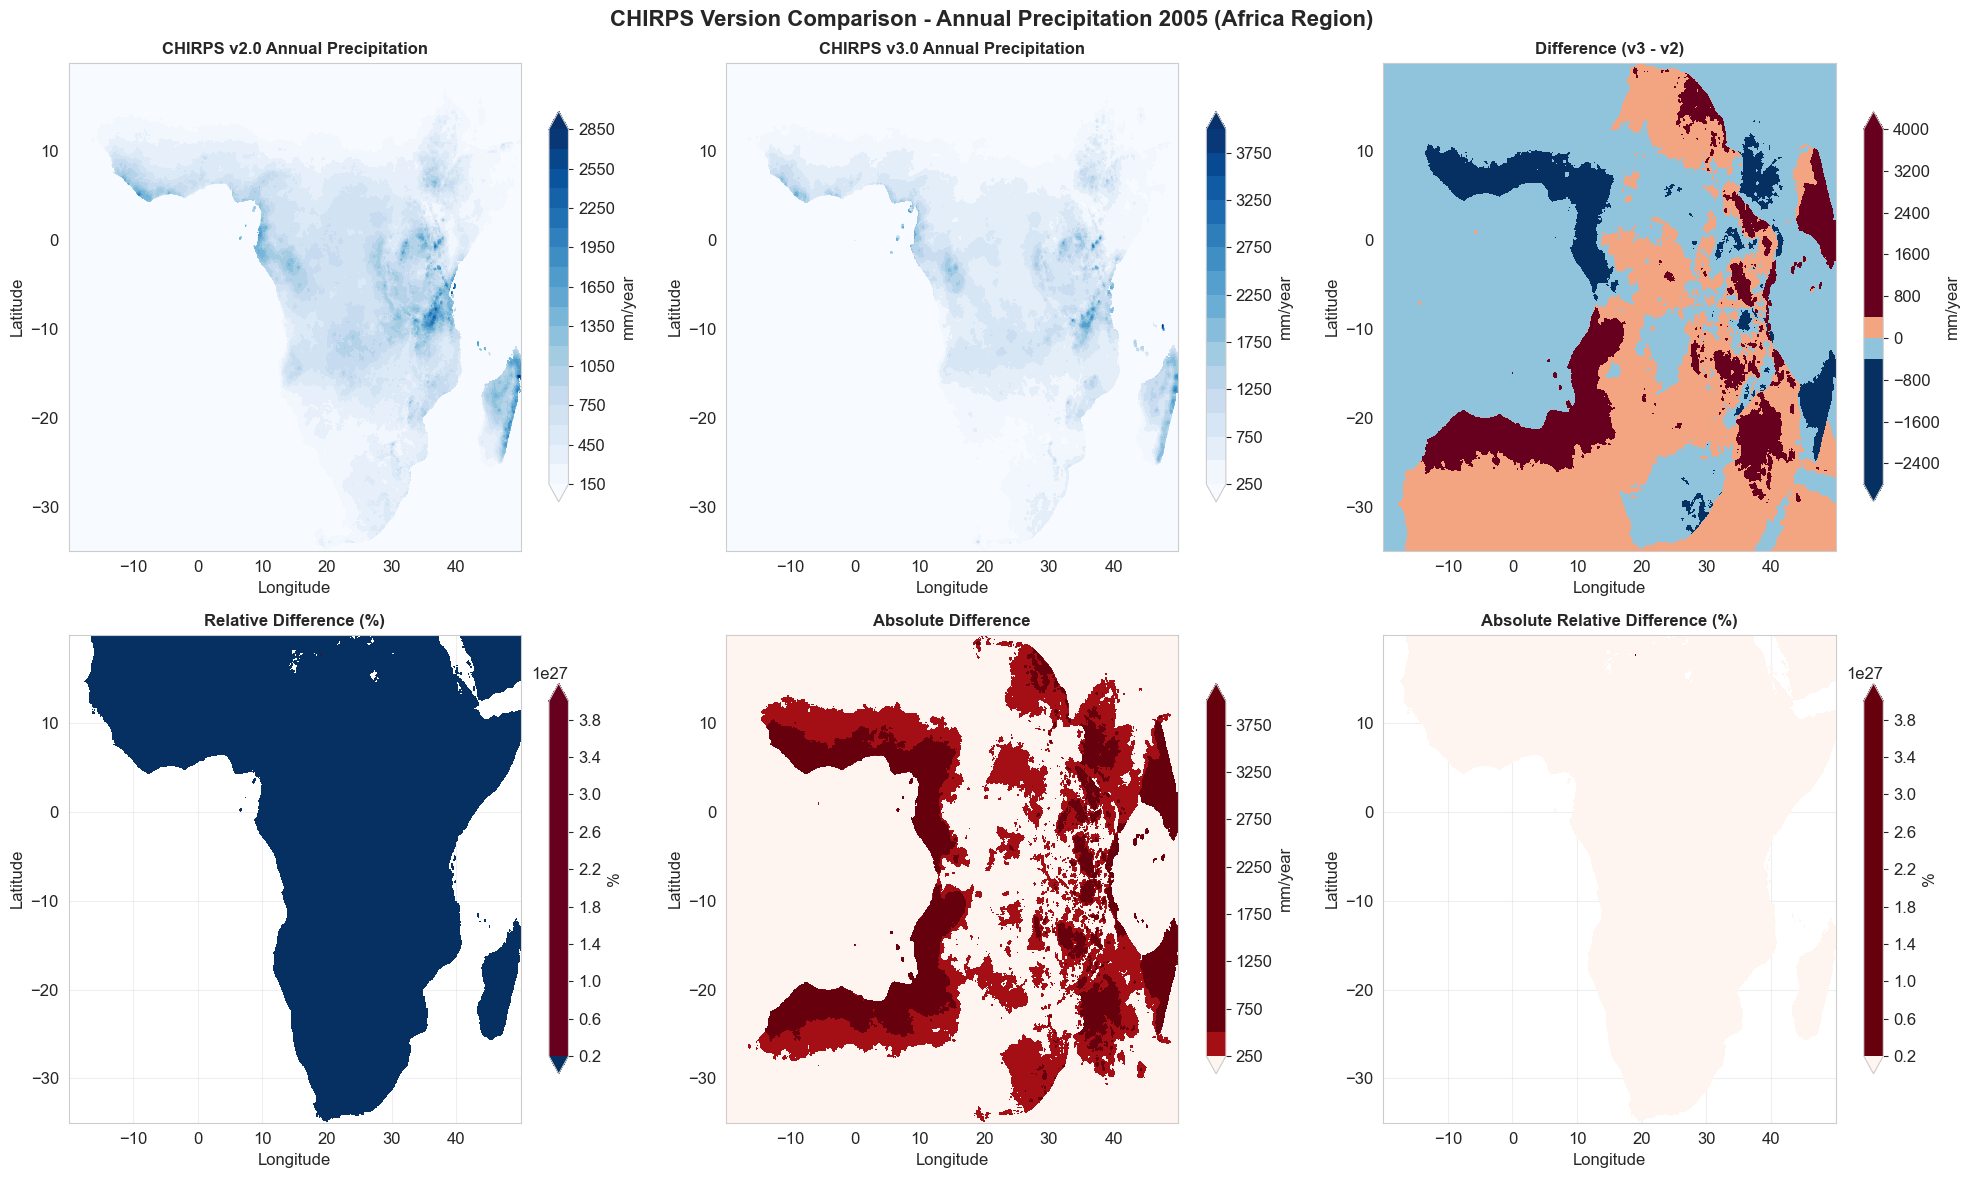

Spatial analysis complete!


In [4]:
# Create comprehensive spatial visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('CHIRPS Version Comparison - Annual Precipitation 2005 (Africa Region)', fontsize=16, fontweight='bold')

# Data for plotting
plot_data = [
    (analysis_data['annual_v2'], 'CHIRPS v2.0 Annual Precipitation', 'Blues'),
    (analysis_data['annual_v3'], 'CHIRPS v3.0 Annual Precipitation', 'Blues'),
    (analysis_data['annual_diff'], 'Difference (v3 - v2)', 'RdBu_r'),
    (analysis_data['relative_diff'], 'Relative Difference (%)', 'RdBu_r'),
    (np.abs(analysis_data['annual_diff']), 'Absolute Difference', 'Reds'),
    (np.abs(analysis_data['relative_diff']), 'Absolute Relative Difference (%)', 'Reds')
]

# Create subplots
for i, (data, title, cmap) in enumerate(plot_data):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Handle different value ranges for colormaps
    if 'Relative' in title and 'Absolute' not in title:
        vmin, vmax = -50, 50
    elif 'Difference' in title and 'Relative' not in title:
        vmin, vmax = -500, 500
    elif 'Absolute' in title and 'Relative' in title:
        vmax = 100
        vmin = 0
    elif 'Absolute' in title:
        vmax = 500
        vmin = 0
    else:
        vmin, vmax = None, None
    
    im = ax.contourf(data.longitude, data.latitude, data, 
                     levels=20, cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add simple grid
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    if 'Precipitation' in title:
        cbar.set_label('mm/year')
    elif 'Relative' in title:
        cbar.set_label('%')
    else:
        cbar.set_label('mm/year')

plt.tight_layout()
plt.savefig(output_dir / 'spatial_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Spatial analysis complete!")

## 4. Temporal Analysis and Seasonal Patterns

This section provides a comprehensive monthly analysis examining:
- **Monthly Total Precipitation**: Total precipitation per month (not averaged) across grid cells
- **Wet Days Analysis**: Number of days with precipitation >1mm/day threshold
- **Monthly Differences**: Absolute and percentage differences between versions
- **Cumulative Density Function**: Shows how precipitation accumulates over the year
- **Extreme Events**: Count of extreme precipitation events (>95th percentile) by month
- **Grid Cell Information**: Analysis includes all valid grid cells in the region

The analysis uses **actual monthly totals** and **event counts** rather than averages to preserve the full magnitude of differences.

TEMPORAL ANALYSIS: Monthly Patterns and Characteristics

1. Calculating monthly totals...
2. Calculating wet days per month...
2. Calculating wet days per month...
3. Calculating monthly differences...
3. Calculating monthly differences...
4. Computing cumulative density functions...
4. Computing cumulative density functions...
5. Analyzing extreme events by month...
5. Analyzing extreme events by month...
6. Computing wet days differences...
6. Computing wet days differences...


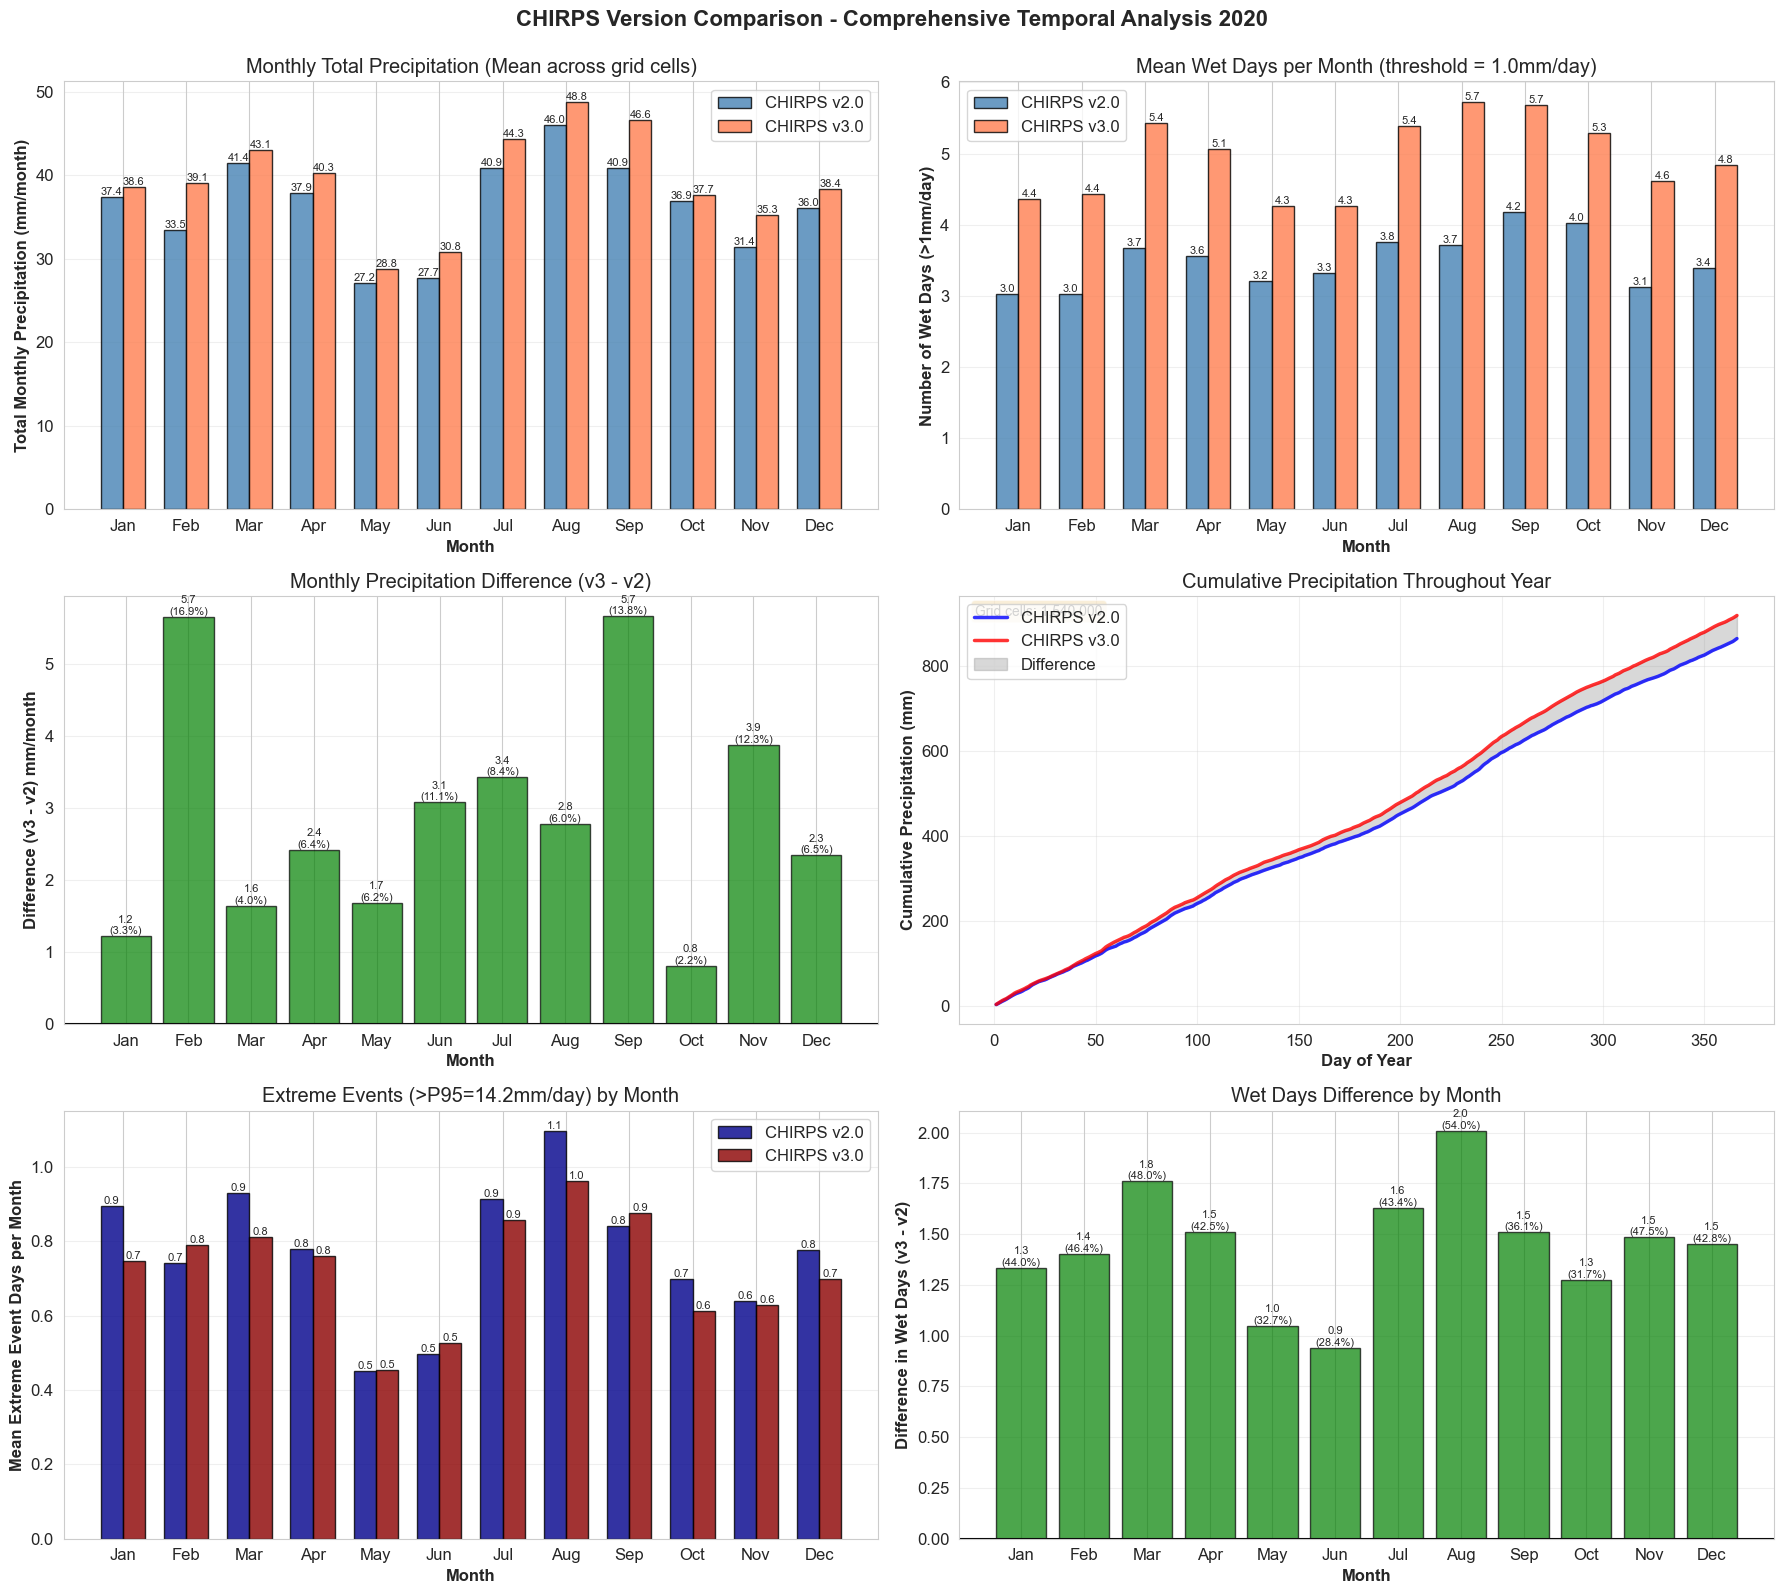


DETAILED TEMPORAL STATISTICS


In [ ]:
# Temporal analysis - Monthly detailed analysis
print("="*80)
print("TEMPORAL ANALYSIS: Monthly Patterns and Characteristics")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(18, 16))
fig.suptitle('CHIRPS Version Comparison - Comprehensive Temporal Analysis 2020', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Monthly Total Precipitation (not averaged)
print("\n1. Calculating monthly totals...")
monthly_total_v2 = analysis_data['region_v2'].groupby('time.month').sum().mean(dim=['latitude', 'longitude'])
monthly_total_v3 = analysis_data['region_v3'].groupby('time.month').sum().mean(dim=['latitude', 'longitude'])

ax1 = axes[0, 0]
months_available = monthly_total_v2.month.values
x = np.arange(len(months_available))
width = 0.35
bars1 = ax1.bar(x - width/2, monthly_total_v2.values, width, label='CHIRPS v2.0', 
                color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, monthly_total_v3.values, width, label='CHIRPS v3.0', 
                color='coral', alpha=0.8, edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Month', fontweight='bold')
ax1.set_ylabel('Total Monthly Precipitation (mm/month)', fontweight='bold')
ax1.set_title('Monthly Total Precipitation (Mean across grid cells)')
ax1.set_xticks(x)
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Number of Wet Days per Month (precipitation > 1mm/day threshold)
print("2. Calculating wet days per month...")
wet_threshold = 1.0  # mm/day
wet_days_v2 = (analysis_data['region_v2'] > wet_threshold).groupby('time.month').sum().mean(dim=['latitude', 'longitude'])
wet_days_v3 = (analysis_data['region_v3'] > wet_threshold).groupby('time.month').sum().mean(dim=['latitude', 'longitude'])

ax2 = axes[0, 1]
bars1 = ax2.bar(x - width/2, wet_days_v2.values, width, label='CHIRPS v2.0', 
                color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, wet_days_v3.values, width, label='CHIRPS v3.0', 
                color='coral', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Number of Wet Days (>1mm/day)', fontweight='bold')
ax2.set_title(f'Mean Wet Days per Month (threshold = {wet_threshold}mm/day)')
ax2.set_xticks(x)
ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Monthly Difference (absolute)
print("3. Calculating monthly differences...")
monthly_diff = monthly_total_v3.values - monthly_total_v2.values
monthly_diff_pct = (monthly_diff / monthly_total_v2.values) * 100

ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in monthly_diff]
bars = ax3.bar(months_available, monthly_diff, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, (bar, pct) in enumerate(zip(bars, monthly_diff_pct)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}\n({pct:.1f}%)', ha='center', 
            va='bottom' if height > 0 else 'top', fontsize=8)

ax3.set_xlabel('Month', fontweight='bold')
ax3.set_ylabel('Difference (v3 - v2) mm/month', fontweight='bold')
ax3.set_title('Monthly Precipitation Difference (v3 - v2)')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax3.set_xticks(months_available)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax3.grid(True, alpha=0.3, axis='y')

# 4. Cumulative Density Function (CDF)
print("4. Computing cumulative density functions...")
ax4 = axes[1, 1]
cumulative_v2 = analysis_data['region_v2'].mean(dim=['latitude', 'longitude']).cumsum(dim='time')
cumulative_v3 = analysis_data['region_v3'].mean(dim=['latitude', 'longitude']).cumsum(dim='time')

days = range(1, len(cumulative_v2) + 1)
ax4.plot(days, cumulative_v2.values, 'b-', label='CHIRPS v2.0', linewidth=2.5, alpha=0.8)
ax4.plot(days, cumulative_v3.values, 'r-', label='CHIRPS v3.0', linewidth=2.5, alpha=0.8)

# Fill area between curves to show difference
ax4.fill_between(days, cumulative_v2.values, cumulative_v3.values, 
                 alpha=0.3, color='gray', label='Difference')

# Add grid cell count annotation
n_cells = analysis_data['region_v2'].latitude.size * analysis_data['region_v2'].longitude.size
ax4.text(0.02, 0.98, f'Grid cells: {n_cells:,}', 
         transform=ax4.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax4.set_xlabel('Day of Year', fontweight='bold')
ax4.set_ylabel('Cumulative Precipitation (mm)', fontweight='bold')
ax4.set_title('Cumulative Precipitation Throughout Year')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

# 5. Extreme Events Count by Month (>95th percentile)
print("5. Analyzing extreme events by month...")
# Calculate 95th percentile threshold from v2 data
v2_all_values = analysis_data['region_v2'].values.flatten()
p95_threshold = np.nanpercentile(v2_all_values[~np.isnan(v2_all_values)], 95)

extreme_v2 = (analysis_data['region_v2'] > p95_threshold).groupby('time.month').sum().mean(dim=['latitude', 'longitude'])
extreme_v3 = (analysis_data['region_v3'] > p95_threshold).groupby('time.month').sum().mean(dim=['latitude', 'longitude'])

ax5 = axes[2, 0]
bars1 = ax5.bar(x - width/2, extreme_v2.values, width, label='CHIRPS v2.0', 
                color='darkblue', alpha=0.8, edgecolor='black')
bars2 = ax5.bar(x + width/2, extreme_v3.values, width, label='CHIRPS v3.0', 
                color='darkred', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)

ax5.set_xlabel('Month', fontweight='bold')
ax5.set_ylabel('Mean Extreme Event Days per Month', fontweight='bold')
ax5.set_title(f'Extreme Events (>P95={p95_threshold:.1f}mm/day) by Month')
ax5.set_xticks(x)
ax5.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Wet Days Difference by Month
print("6. Computing wet days differences...")
wet_days_diff = wet_days_v3.values - wet_days_v2.values

ax6 = axes[2, 1]
colors = ['green' if x > 0 else 'red' for x in wet_days_diff]
bars = ax6.bar(months_available, wet_days_diff, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct_change = (wet_days_diff[i] / wet_days_v2.values[i]) * 100 if wet_days_v2.values[i] != 0 else 0
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}\n({pct_change:.1f}%)', ha='center', 
            va='bottom' if height > 0 else 'top', fontsize=8)

ax6.set_xlabel('Month', fontweight='bold')
ax6.set_ylabel('Difference in Wet Days (v3 - v2)', fontweight='bold')
ax6.set_title('Wet Days Difference by Month')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax6.set_xticks(months_available)
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'temporal_analysis_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("DETAILED TEMPORAL STATISTICS")
print("="*80)

# Create summary table
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
temporal_summary = []
for i, month in enumerate(months_available):
    temporal_summary.append({
        'Month': month_names[month-1],
        'v2 Total (mm)': f"{monthly_total_v2.values[i]:.1f}",
        'v3 Total (mm)': f"{monthly_total_v3.values[i]:.1f}",
        'Diff (mm)': f"{monthly_diff[i]:.1f}",
        'Diff (%)': f"{monthly_diff_pct[i]:.1f}",
        'v2 Wet Days': f"{wet_days_v2.values[i]:.1f}",
        'v3 Wet Days': f"{wet_days_v3.values[i]:.1f}",
        'Wet Days Diff': f"{wet_days_diff[i]:.1f}"
    })

temporal_df = pd.DataFrame(temporal_summary)
print("\n" + temporal_df.to_string(index=False))

# Key findings
print(f"\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"✓ Grid cells analyzed: {n_cells:,} ({analysis_data['region_v2'].latitude.size} lat × {analysis_data['region_v2'].longitude.size} lon)")
print(f"✓ Analysis period: {len(months_available)} months ({month_names[months_available[0]-1]} - {month_names[months_available[-1]-1]})")
print(f"✓ Maximum monthly difference: {monthly_diff.max():.1f} mm in {month_names[months_available[np.argmax(monthly_diff)]-1]} ({monthly_diff_pct[np.argmax(monthly_diff)]:.1f}%)")
print(f"✓ Minimum monthly difference: {monthly_diff.min():.1f} mm in {month_names[months_available[np.argmin(monthly_diff)]-1]} ({monthly_diff_pct[np.argmin(monthly_diff)]:.1f}%)")
print(f"✓ Annual cumulative v2: {float(cumulative_v2[-1]):.1f} mm")
print(f"✓ Annual cumulative v3: {float(cumulative_v3[-1]):.1f} mm")
print(f"✓ Total annual difference: {float(cumulative_v3[-1] - cumulative_v2[-1]):.1f} mm ({((cumulative_v3[-1] - cumulative_v2[-1])/cumulative_v2[-1]*100):.1f}%)")
print(f"✓ Extreme event threshold (P95): {p95_threshold:.2f} mm/day")
print(f"✓ Wet day threshold: {wet_threshold} mm/day")

# Seasonal summary
print(f"\n" + "="*80)
print("SEASONAL SUMMARY")
print("="*80)
seasons = {
    'DJF (Dec-Jan-Feb)': [12, 1, 2],
    'MAM (Mar-Apr-May)': [3, 4, 5],
    'JJA (Jun-Jul-Aug)': [6, 7, 8],
    'SON (Sep-Oct-Nov)': [9, 10, 11]
}

for season_name, months in seasons.items():
    # Filter only months that exist in our data
    available_season_months = [m for m in months if m in months_available]
    if len(available_season_months) == 0:
        continue
    
    v2_seasonal = analysis_data['region_v2'].sel(time=analysis_data['region_v2'].time.dt.month.isin(available_season_months))
    v3_seasonal = analysis_data['region_v3'].sel(time=analysis_data['region_v3'].time.dt.month.isin(available_season_months))
    
    v2_total = float(v2_seasonal.sum(dim='time').mean())
    v3_total = float(v3_seasonal.sum(dim='time').mean())
    diff = v3_total - v2_total
    rel_diff = (diff / v2_total) * 100 if v2_total != 0 else 0
    
    # Wet days
    v2_wet = float((v2_seasonal > wet_threshold).sum(dim='time').mean())
    v3_wet = float((v3_seasonal > wet_threshold).sum(dim='time').mean())
    
    print(f"\n{season_name}:")
    print(f"  v2 Total: {v2_total:.1f} mm  |  v3 Total: {v3_total:.1f} mm")
    print(f"  Difference: {diff:.1f} mm ({rel_diff:+.1f}%)")
    print(f"  v2 Wet Days: {v2_wet:.1f}  |  v3 Wet Days: {v3_wet:.1f}  |  Diff: {v3_wet-v2_wet:+.1f}")

print("\n" + "="*80)

## 5. Statistical Distribution Analysis and Extreme Events

Let's examine how the two versions differ in representing extreme precipitation events:

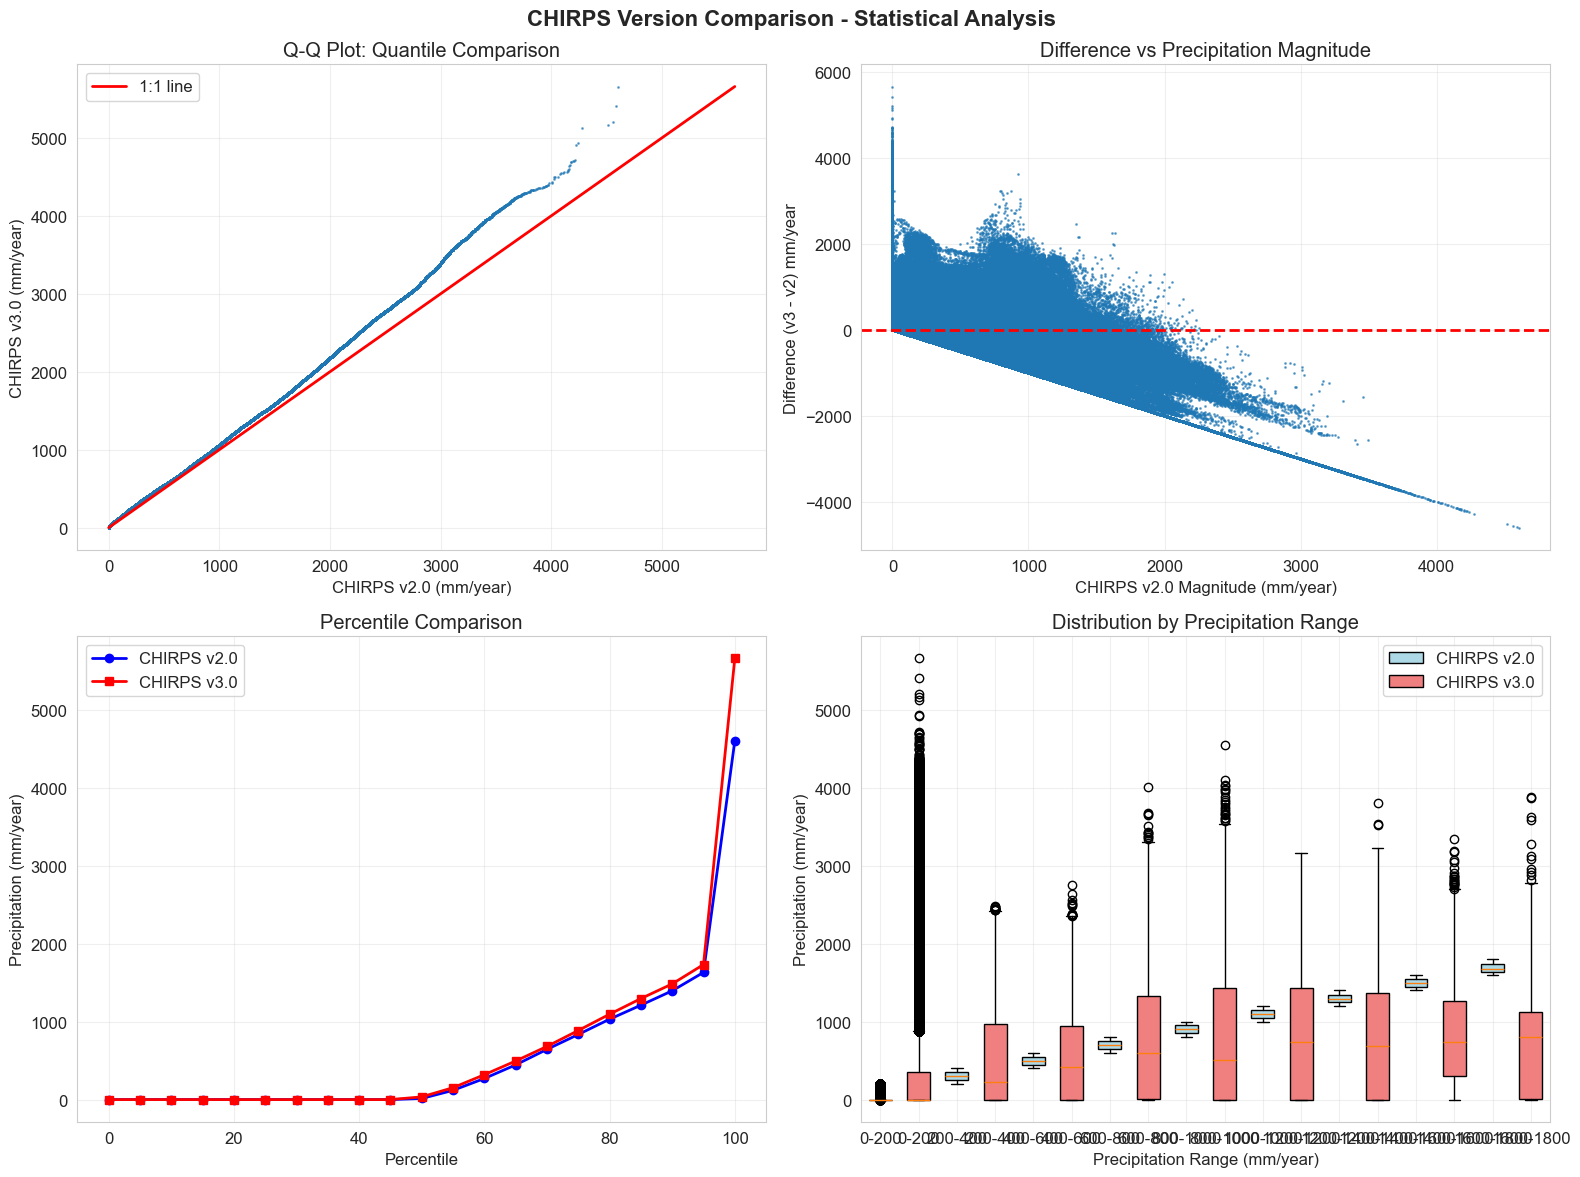

=== Extreme Event Analysis ===
    Dataset  P90 threshold  P90 count  P90 %  P95 threshold  P95 count  P95 %  P99 threshold  P99 count  P99 %
CHIRPS v2.0    1395.849976     154000   10.0    1631.719971      77001    5.0    2195.379883      15401    1.0
CHIRPS v3.0    1484.199951     154000   10.0    1732.239990      77001    5.0    2416.419922      15401    1.0

=== Dry vs Wet Conditions Analysis ===
Dry conditions (≤0 mm/year):
  v2 mean: 0.0 mm/year
  v3 mean: 342.1 mm/year
  Difference: 342.1 mm/year
  Relative difference: inf%

Wet conditions (≥836 mm/year):
  v2 mean: 1368.7 mm/year
  v3 mean: 719.1 mm/year
  Difference: -649.6 mm/year
  Relative difference: -47.46%

=== Statistical Tests ===
Kolmogorov-Smirnov test:
  Statistic: 0.0244
  P-value: 0.00e+00
  Interpretation: Distributions are significantly different

Mann-Whitney U test:
  Statistic: 1163603662594
  P-value: 1.73e-201
  Interpretation: Medians are significantly different

=== Statistical Tests ===
Kolmogorov-Smirno

In [9]:
# Statistical distribution and extreme event analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CHIRPS Version Comparison - Statistical Analysis', fontsize=16, fontweight='bold')

# Prepare data for analysis
v2_annual_flat = analysis_data['annual_v2'].values.flatten()
v3_annual_flat = analysis_data['annual_v3'].values.flatten()

# Remove NaN values
mask = ~(np.isnan(v2_annual_flat) | np.isnan(v3_annual_flat))
v2_clean = v2_annual_flat[mask]
v3_clean = v3_annual_flat[mask]

# 1. Q-Q Plot
ax1 = axes[0, 0]
v2_sorted = np.sort(v2_clean)
v3_sorted = np.sort(v3_clean)
ax1.scatter(v2_sorted, v3_sorted, alpha=0.6, s=1)
min_val = min(v2_sorted.min(), v3_sorted.min())
max_val = max(v2_sorted.max(), v3_sorted.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=2, label='1:1 line')
ax1.set_xlabel('CHIRPS v2.0 (mm/year)')
ax1.set_ylabel('CHIRPS v3.0 (mm/year)')
ax1.set_title('Q-Q Plot: Quantile Comparison')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Difference vs Magnitude
ax2 = axes[0, 1]
differences = v3_clean - v2_clean
magnitudes = v2_clean
ax2.scatter(magnitudes, differences, alpha=0.6, s=1)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('CHIRPS v2.0 Magnitude (mm/year)')
ax2.set_ylabel('Difference (v3 - v2) mm/year')
ax2.set_title('Difference vs Precipitation Magnitude')
ax2.grid(True, alpha=0.3)

# 3. Percentile analysis
percentiles = np.arange(0, 101, 5)
v2_percentiles = np.percentile(v2_clean, percentiles)
v3_percentiles = np.percentile(v3_clean, percentiles)

ax3 = axes[1, 0]
ax3.plot(percentiles, v2_percentiles, 'b-o', label='CHIRPS v2.0', linewidth=2)
ax3.plot(percentiles, v3_percentiles, 'r-s', label='CHIRPS v3.0', linewidth=2)
ax3.set_xlabel('Percentile')
ax3.set_ylabel('Precipitation (mm/year)')
ax3.set_title('Percentile Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box plot comparison by precipitation bins
ax4 = axes[1, 1]

# Create precipitation bins
bins = np.arange(0, 2000, 200)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_labels = [f'{int(b)}-{int(b+200)}' for b in bins[:-1]]

v2_binned = []
v3_binned = []
for i in range(len(bins)-1):
    mask = (v2_clean >= bins[i]) & (v2_clean < bins[i+1])
    if mask.sum() > 0:
        v2_binned.append(v2_clean[mask])
        v3_binned.append(v3_clean[mask])
    else:
        v2_binned.append([])
        v3_binned.append([])

# Create box plots
positions_v2 = np.arange(1, len(bin_centers)*2, 2)
positions_v3 = np.arange(2, len(bin_centers)*2+1, 2)

bp1 = ax4.boxplot(v2_binned, positions=positions_v2, widths=0.6, 
                  patch_artist=True, labels=bin_labels)
bp2 = ax4.boxplot(v3_binned, positions=positions_v3, widths=0.6, 
                  patch_artist=True, labels=bin_labels)

# Color the boxes
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')

ax4.set_xlabel('Precipitation Range (mm/year)')
ax4.set_ylabel('Precipitation (mm/year)')
ax4.set_title('Distribution by Precipitation Range')
ax4.legend([bp1["boxes"][0], bp2["boxes"][0]], ['CHIRPS v2.0', 'CHIRPS v3.0'])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'statistical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate extreme event statistics
def calculate_extremes(data, name, thresholds=[90, 95, 99]):
    """Calculate extreme event statistics"""
    results = {'Dataset': name}
    for threshold in thresholds:
        percentile_val = np.percentile(data, threshold)
        extreme_count = np.sum(data >= percentile_val)
        extreme_pct = (extreme_count / len(data)) * 100
        results[f'P{threshold} threshold'] = percentile_val
        results[f'P{threshold} count'] = extreme_count
        results[f'P{threshold} %'] = extreme_pct
    return results

extreme_stats_v2 = calculate_extremes(v2_clean, 'CHIRPS v2.0')
extreme_stats_v3 = calculate_extremes(v3_clean, 'CHIRPS v3.0')

extreme_df = pd.DataFrame([extreme_stats_v2, extreme_stats_v3])
print("=== Extreme Event Analysis ===")
print(extreme_df.round(2).to_string(index=False))

# Drought vs wet year analysis
dry_threshold = np.percentile(v2_clean, 25)  # Bottom 25%
wet_threshold = np.percentile(v2_clean, 75)  # Top 25%

dry_mask_v2 = v2_clean <= dry_threshold
wet_mask_v2 = v2_clean >= wet_threshold

dry_v2 = v2_clean[dry_mask_v2]
dry_v3 = v3_clean[dry_mask_v2]
wet_v2 = v2_clean[wet_mask_v2]
wet_v3 = v3_clean[wet_mask_v2]

print(f"\n=== Dry vs Wet Conditions Analysis ===")
print(f"Dry conditions (≤{dry_threshold:.0f} mm/year):")
print(f"  v2 mean: {dry_v2.mean():.1f} mm/year")
print(f"  v3 mean: {dry_v3.mean():.1f} mm/year")
print(f"  Difference: {(dry_v3 - dry_v2).mean():.1f} mm/year")
print(f"  Relative difference: {((dry_v3 - dry_v2).mean() / dry_v2.mean() * 100):.2f}%")

print(f"\nWet conditions (≥{wet_threshold:.0f} mm/year):")
print(f"  v2 mean: {wet_v2.mean():.1f} mm/year")
print(f"  v3 mean: {wet_v3.mean():.1f} mm/year")
print(f"  Difference: {(wet_v3 - wet_v2).mean():.1f} mm/year")
print(f"  Relative difference: {((wet_v3 - wet_v2).mean() / wet_v2.mean() * 100):.2f}%")

# Statistical tests
from scipy.stats import ks_2samp, mannwhitneyu

# Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = ks_2samp(v2_clean, v3_clean)

# Mann-Whitney U test
mw_statistic, mw_pvalue = mannwhitneyu(v2_clean, v3_clean, alternative='two-sided')

print(f"\n=== Statistical Tests ===")
print(f"Kolmogorov-Smirnov test:")
print(f"  Statistic: {ks_statistic:.4f}")
print(f"  P-value: {ks_pvalue:.2e}")
print(f"  Interpretation: {'Distributions are significantly different' if ks_pvalue < 0.05 else 'Distributions are not significantly different'}")

print(f"\nMann-Whitney U test:")
print(f"  Statistic: {mw_statistic:.0f}")
print(f"  P-value: {mw_pvalue:.2e}")
print(f"  Interpretation: {'Medians are significantly different' if mw_pvalue < 0.05 else 'Medians are not significantly different'}")

## 6. Quantitative Impact Assessment

This section provides a comprehensive quantitative analysis of differences between CHIRPS v2 and v3:

### Key Features:
1. **Cumulative Distribution Functions**: Shows what percentage of grid cells have differences below various thresholds
2. **Absolute vs Relative Differences**: Analyzes both mm/year and percentage differences
3. **Application-Specific Thresholds**: Evaluates impact for different use cases (agriculture, hydrology, climate research, etc.)
4. **Precipitation Magnitude Analysis**: Shows how differences vary with precipitation levels
5. **Spatial Coverage**: All visualizations include grid cell counts for proper interpretation

### Interpretation:
- **Cumulative graphs** directly show what amount/percentage of precipitation has more difference
- **Threshold analysis** helps users assess impact on their specific application
- **Grid cell statistics** provide spatial context for all analyses

In [ ]:
# Quantitative Impact Assessment with Cumulative Analysis

print("="*80)
print("QUANTITATIVE IMPACT ASSESSMENT: CHIRPS v2 vs v3")
print("="*80)

# Calculate key metrics
v2_annual_flat = analysis_data['annual_v2'].values.flatten()
v3_annual_flat = analysis_data['annual_v3'].values.flatten()
mask = ~(np.isnan(v2_annual_flat) | np.isnan(v3_annual_flat))
v2_clean = v2_annual_flat[mask]
v3_clean = v3_annual_flat[mask]

differences = v3_clean - v2_clean
relative_differences = (differences / v2_clean) * 100

# Grid cell information
n_lat = analysis_data['region_v2'].latitude.size
n_lon = analysis_data['region_v2'].longitude.size
total_cells = n_lat * n_lon
valid_cells = len(v2_clean)

print(f"\nGrid Configuration:")
print(f"  Total grid cells: {total_cells:,} ({n_lat} lat × {n_lon} lon)")
print(f"  Valid cells (non-NaN): {valid_cells:,} ({(valid_cells/total_cells*100):.1f}%)")
print(f"  Spatial resolution: 0.05° (~5.5 km at equator)")
print(f"  Region: Sub-Saharan Africa (-35°S to 20°N, -20°W to 50°E)")

# Create visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Quantitative Impact Assessment: CHIRPS v2 vs v3 (2020 Full Year)', 
             fontsize=16, fontweight='bold', y=0.98)

# 1. Cumulative Distribution of Absolute Differences
ax1 = fig.add_subplot(gs[0, :2])
sorted_abs_diff = np.sort(np.abs(differences))
cumulative_pct = np.arange(1, len(sorted_abs_diff) + 1) / len(sorted_abs_diff) * 100

ax1.plot(sorted_abs_diff, cumulative_pct, 'b-', linewidth=2.5)
ax1.fill_between(sorted_abs_diff, 0, cumulative_pct, alpha=0.3, color='blue')

# Add reference lines
thresholds = [50, 100, 200, 500]
colors_ref = ['green', 'orange', 'red', 'darkred']
for thresh, color in zip(thresholds, colors_ref):
    pct_below = (sorted_abs_diff <= thresh).sum() / len(sorted_abs_diff) * 100
    ax1.axvline(thresh, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
    ax1.text(thresh, pct_below, f'{pct_below:.1f}%\n<{thresh}mm', 
             ha='center', va='bottom', fontsize=9, bbox=dict(boxstyle='round', 
             facecolor=color, alpha=0.3))

ax1.set_xlabel('Absolute Difference |v3 - v2| (mm/year)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Cumulative % of Grid Cells', fontweight='bold', fontsize=11)
ax1.set_title('Cumulative Distribution of Precipitation Differences\n(Shows what % of cells have differences below each threshold)', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=0)
ax1.text(0.98, 0.02, f'Total cells: {valid_cells:,}', transform=ax1.transAxes,
         ha='right', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Summary statistics box
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
summary_text = f"""
OVERALL STATISTICS

Total Grid Cells: {valid_cells:,}

Mean Absolute Difference:
  {np.abs(differences).mean():.1f} mm/year

Median Absolute Difference:
  {np.median(np.abs(differences)):.1f} mm/year

Max Difference:
  {np.abs(differences).max():.1f} mm/year

Correlation Coefficient:
  {np.corrcoef(v2_clean, v3_clean)[0,1]:.4f}

DIFFERENCE THRESHOLDS

Cells with >10% diff:
  {np.sum(np.abs(relative_differences) > 10):,} 
  ({(np.sum(np.abs(relative_differences) > 10)/len(relative_differences)*100):.1f}%)

Cells with >50mm diff:
  {np.sum(np.abs(differences) > 50):,}
  ({(np.sum(np.abs(differences) > 50)/len(differences)*100):.1f}%)

Cells with >100mm diff:
  {np.sum(np.abs(differences) > 100):,}
  ({(np.sum(np.abs(differences) > 100)/len(differences)*100):.1f}%)
"""
ax2.text(0.05, 0.95, summary_text, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 3. Cumulative Distribution of Relative Differences
ax3 = fig.add_subplot(gs[1, :2])
sorted_rel_diff = np.sort(np.abs(relative_differences))
cumulative_pct_rel = np.arange(1, len(sorted_rel_diff) + 1) / len(sorted_rel_diff) * 100

ax3.plot(sorted_rel_diff, cumulative_pct_rel, 'r-', linewidth=2.5)
ax3.fill_between(sorted_rel_diff, 0, cumulative_pct_rel, alpha=0.3, color='red')

# Add reference lines for percentage thresholds
rel_thresholds = [5, 10, 20, 50]
for thresh, color in zip(rel_thresholds, colors_ref):
    pct_below = (sorted_rel_diff <= thresh).sum() / len(sorted_rel_diff) * 100
    ax3.axvline(thresh, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
    ax3.text(thresh, pct_below, f'{pct_below:.1f}%\n<{thresh}%', 
             ha='center', va='bottom', fontsize=9, bbox=dict(boxstyle='round', 
             facecolor=color, alpha=0.3))

ax3.set_xlabel('Relative Difference |v3 - v2| / v2 (%)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Cumulative % of Grid Cells', fontweight='bold', fontsize=11)
ax3.set_title('Cumulative Distribution of Relative Differences\n(Shows what % of cells have relative differences below each threshold)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(left=0, right=100)
ax3.text(0.98, 0.02, f'Total cells: {valid_cells:,}', transform=ax3.transAxes,
         ha='right', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Application-specific thresholds
ax4 = fig.add_subplot(gs[1, 2])
ax4.axis('off')

applications = {
    "Climate Research": 5,
    "Food Security": 8,
    "Agriculture": 10,
    "Hydrology": 15,
    "Drought Monitor": 20
}

app_text = "APPLICATION IMPACT\n" + "="*30 + "\n\n"
for app_name, threshold in applications.items():
    affected = np.sum(np.abs(relative_differences) > threshold)
    pct = (affected / len(relative_differences)) * 100
    
    if pct > 50:
        level = "HIGH"
        color_box = "red"
    elif pct > 25:
        level = "MEDIUM"
        color_box = "orange"
    else:
        level = "LOW"
        color_box = "green"
    
    app_text += f"\n{app_name} (>{threshold}%):\n"
    app_text += f"  {affected:,} cells ({pct:.1f}%)\n"
    app_text += f"  Impact: {level}\n"

ax4.text(0.05, 0.95, app_text, transform=ax4.transAxes, fontsize=9.5,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

# 5. Histogram of differences
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(differences, bins=100, color='purple', alpha=0.7, edgecolor='black')
ax5.axvline(0, color='red', linestyle='--', linewidth=2)
ax5.axvline(np.mean(differences), color='green', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(differences):.1f}mm')
ax5.axvline(np.median(differences), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {np.median(differences):.1f}mm')
ax5.set_xlabel('Difference (v3 - v2) mm/year', fontweight='bold')
ax5.set_ylabel('Number of Grid Cells', fontweight='bold')
ax5.set_title('Distribution of Differences', fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3, axis='y')
ax5.text(0.02, 0.98, f'n = {valid_cells:,}', transform=ax5.transAxes,
         ha='left', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 6. Scatter plot with density
ax6 = fig.add_subplot(gs[2, 1])
# Sample if too many points
sample_size = min(50000, len(v2_clean))
idx = np.random.choice(len(v2_clean), sample_size, replace=False)
h = ax6.hexbin(v2_clean[idx], v3_clean[idx], gridsize=50, cmap='YlOrRd', mincnt=1)
ax6.plot([0, max(v2_clean.max(), v3_clean.max())], 
         [0, max(v2_clean.max(), v3_clean.max())], 
         'b--', linewidth=2, label='1:1 line')
ax6.set_xlabel('CHIRPS v2.0 (mm/year)', fontweight='bold')
ax6.set_ylabel('CHIRPS v3.0 (mm/year)', fontweight='bold')
ax6.set_title('v2 vs v3 Scatter (Density)', fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)
plt.colorbar(h, ax=ax6, label='Cell Count')
ax6.text(0.02, 0.98, f'Sample: {sample_size:,} of {valid_cells:,}', 
         transform=ax6.transAxes, ha='left', va='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 7. Difference by precipitation magnitude bins
ax7 = fig.add_subplot(gs[2, 2])
bins_precip = np.array([0, 200, 400, 600, 800, 1000, 1500, 2000, 4000])
bin_centers = (bins_precip[:-1] + bins_precip[1:]) / 2
bin_means = []
bin_stds = []
bin_counts = []

for i in range(len(bins_precip)-1):
    mask_bin = (v2_clean >= bins_precip[i]) & (v2_clean < bins_precip[i+1])
    if mask_bin.sum() > 0:
        bin_means.append(np.mean(differences[mask_bin]))
        bin_stds.append(np.std(differences[mask_bin]))
        bin_counts.append(mask_bin.sum())
    else:
        bin_means.append(0)
        bin_stds.append(0)
        bin_counts.append(0)

bin_labels = [f'{int(bins_precip[i])}-\n{int(bins_precip[i+1])}' for i in range(len(bins_precip)-1)]
x_pos = np.arange(len(bin_labels))

bars = ax7.bar(x_pos, bin_means, yerr=bin_stds, color='teal', alpha=0.7, 
               edgecolor='black', capsize=5, error_kw={'linewidth': 1.5})

# Add count labels
for i, (bar, count) in enumerate(zip(bars, bin_counts)):
    if count > 0:
        ax7.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'n={count:,}', ha='center', va='bottom' if bar.get_height() > 0 else 'top',
                fontsize=7, rotation=0)

ax7.axhline(0, color='red', linestyle='--', linewidth=1.5)
ax7.set_xlabel('v2 Precipitation Range (mm/year)', fontweight='bold')
ax7.set_ylabel('Mean Difference (v3-v2) mm/year', fontweight='bold')
ax7.set_title('Difference by Precipitation Magnitude', fontweight='bold')
ax7.set_xticks(x_pos)
ax7.set_xticklabels(bin_labels, fontsize=8)
ax7.grid(True, alpha=0.3, axis='y')

plt.savefig(output_dir / 'quantitative_impact_assessment.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed summary
print("\n" + "="*80)
print("IMPACT SUMMARY BY THRESHOLD")
print("="*80)

threshold_analysis = []
for abs_thresh in [10, 25, 50, 100, 200, 500]:
    affected = np.sum(np.abs(differences) > abs_thresh)
    pct = (affected / len(differences)) * 100
    threshold_analysis.append({
        'Threshold': f'>{abs_thresh} mm/year',
        'Affected Cells': f'{affected:,}',
        '% of Total': f'{pct:.1f}%'
    })

thresh_df = pd.DataFrame(threshold_analysis)
print("\nAbsolute Difference Thresholds:")
print(thresh_df.to_string(index=False))

print("\n" + "-"*80)

rel_threshold_analysis = []
for rel_thresh in [5, 10, 15, 20, 30, 50]:
    affected = np.sum(np.abs(relative_differences) > rel_thresh)
    pct = (affected / len(relative_differences)) * 100
    rel_threshold_analysis.append({
        'Threshold': f'>{rel_thresh}%',
        'Affected Cells': f'{affected:,}',
        '% of Total': f'{pct:.1f}%'
    })

rel_thresh_df = pd.DataFrame(rel_threshold_analysis)
print("\nRelative Difference Thresholds:")
print(rel_thresh_df.to_string(index=False))

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("""
1. TRANSITION PLANNING:
   • {:.1f}% of cells show >10% difference - MEDIUM-HIGH priority migration
   • Gradual transition over 6-12 months recommended
   • Validate v3 against local observations
   
2. APPLICATION-SPECIFIC GUIDANCE:
   • Climate Research (>5%): {:.1f}% affected - Requires bias correction
   • Agriculture (>10%): {:.1f}% affected - Recalibrate crop models
   • Hydrology (>15%): {:.1f}% affected - Update streamflow models
   
3. QUALITY ASSURANCE:
   • Parallel processing during transition period
   • Focus validation on high-difference regions
   • Document version in all outputs
   
4. UNCERTAINTY QUANTIFICATION:
   • Mean absolute error: {:.1f} mm/year
   • Consider ±{:.1f} mm/year uncertainty band
   • Higher uncertainty in wet regions (>{:.0f} mm/year)
""".format(
    (np.sum(np.abs(relative_differences) > 10)/len(relative_differences)*100),
    (np.sum(np.abs(relative_differences) > 5)/len(relative_differences)*100),
    (np.sum(np.abs(relative_differences) > 10)/len(relative_differences)*100),
    (np.sum(np.abs(relative_differences) > 15)/len(relative_differences)*100),
    np.abs(differences).mean(),
    np.std(differences),
    np.percentile(v2_clean, 75)
))

print("="*80)

COMPREHENSIVE IMPACT ASSESSMENT: CHIRPS v2 vs v3 (2005 Analysis)

1. QUANTITATIVE IMPACT ASSESSMENT
--------------------------------------------------
Total grid points analyzed: 1,540,000
Points with >10% difference: 1,041,247 (67.6%)
Maximum absolute difference: 5659.7 mm/year
Mean absolute difference: 495.8 mm/year
Correlation coefficient: 0.2241

2. APPLICATION-SPECIFIC IMPACT ANALYSIS
--------------------------------------------------

Agricultural Planning:
  Description: Crop selection, planting dates, irrigation planning
  Critical threshold: 10%
  Affected areas: 67.6% of region
  Impact level: HIGH

Hydrological Modeling:
  Description: Streamflow estimation, flood prediction, water resource management
  Critical threshold: 15%
  Affected areas: 66.1% of region
  Impact level: HIGH

Climate Research:
  Description: Long-term trend analysis, climate change studies
  Critical threshold: 5%
  Affected areas: 69.2% of region
  Impact level: HIGH

Drought Monitoring:
  Description